<a href="https://colab.research.google.com/github/starkjiang/TrAC-Generative-Models/blob/main/gan_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Tutorial

In this tutorial, we will implement the generative adversarial network (GAN) and use it to generate new data samples. This tutorial does not aim to get the best model, instead, focusing more on how to build the discriminator and generator.

**Key Aspects**



*   Build the discriminator and generator
*   Define the loss function
*   Select the size for the latent representation of the sample
*   Training the model





# GAN Loss

The generator loss is $\mathcal{L}_G=-\mathbb{E}_{z\sim p(z)}[\text{log}(1-D(G(z)))]$.

The discriminator loss is $\mathcal{L}_D=-\mathbb{E}_{x\sim p_{data}}[\text{log}D(x)]-\mathbb{E}_{z\sim p(z)}[\text{log}(1-D(G(z)))]$

You should use the `bce_loss` function defined below to compute the binary cross entropy loss which is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ (the probability of a class) and a label $y\in\{0,1\}$, the binary cross-entropy loss is

$\mathcal{L}_B(s,y)=-y\text{log}(s)-(1-y)\text{log}(1-s)$


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.35MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.80MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[0/5][0/938] Loss_D: 1.3581 Loss_G: 0.7210
[0/5][100/938] Loss_D: 0.1899 Loss_G: 3.3430
[0/5][200/938] Loss_D: 0.0151 Loss_G: 5.3500
[0/5][300/938] Loss_D: 1.1270 Loss_G: 3.6199
[0/5][400/938] Loss_D: 0.0411 Loss_G: 5.7329
[0/5][500/938] Loss_D: 0.4414 Loss_G: 4.1892
[0/5][600/938] Loss_D: 0.0647 Loss_G: 5.1234
[0/5][700/938] Loss_D: 0.1735 Loss_G: 5.2499
[0/5][800/938] Loss_D: 0.2585 Loss_G: 3.3353
[0/5][900/938] Loss_D: 0.2071 Loss_G: 3.2306
[1/5][0/938] Loss_D: 0.5968 Loss_G: 2.8282
[1/5][100/938] Loss_D: 0.1421 Loss_G: 4.2661
[1/5][200/938] Loss_D: 0.8779 Loss_G: 1.9008
[1/5][300/938] Loss_D: 0.4643 Loss_G: 3.3412
[1/5][400/938] Loss_D: 0.4382 Loss_G: 3.1593
[1/5][500/938] Loss_D: 0.4401 Loss_G: 3.1741
[1/5][600/938] Loss_D: 1.4477 Loss_G: 1.4101
[1/5][700/938] Loss_D: 0.5183 Loss_G: 4.0812
[1/5][800/938] Loss_D: 1.1337 Loss_G: 1.5824
[1/5][900/938] Loss_D: 0.4390 Loss_G: 2.8019
[2/5][0/938] Loss_D: 0.6654 L

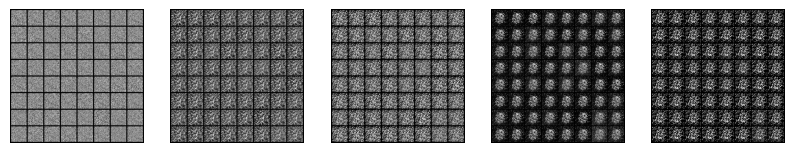

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),  # 28x28 for MNIST
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input.view(-1, 784))

# Initialize networks and optimizers
netG = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 5
fixed_noise = torch.randn(64, 100, device=device)
img_list = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_data = data[0].to(device)
        label = torch.full(
            (real_data.size(0), 1), 1, dtype=torch.float, device=device)
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(real_data.size(0), 100, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Print and plot
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD_real.item() + errD_fake.item():.4f} Loss_G: {errG.item():.4f}')
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

# Plot generated images
plt.figure(figsize=(10, 5))
for i, img in enumerate(img_list):
    if i >= 5: # Ad-hoc! Adjust if needed
        break
    plt.subplot(1, 5, i+1) # Adjust if you have more epochs
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
plt.show()

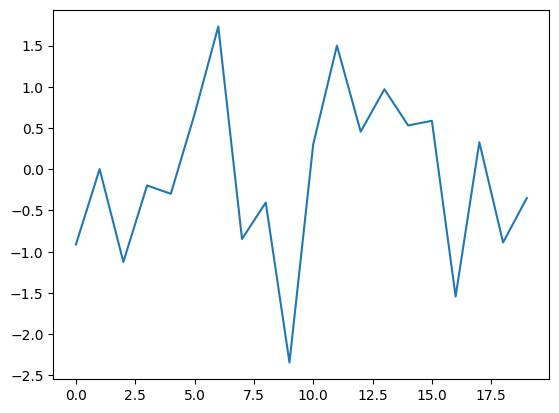

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = 100  # Noise input size
hidden_size = 128
sequence_length = 20
batch_size = 64
epochs = 10000
lr = 0.0002

# Sample data (replace with your real time series data)
real_data = torch.randn(1000, sequence_length)

# Create DataLoader
dataset = TensorDataset(real_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize Generator and Discriminator
generator = Generator(input_size, hidden_size, sequence_length)
discriminator = Discriminator(sequence_length, hidden_size)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for i, data in enumerate(dataloader):
        real_samples = data[0]

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_samples.size(0), 1)
        noise = torch.randn(real_samples.size(0), input_size)
        fake_samples = generator(noise)
        fake_labels = torch.zeros(fake_samples.size(0), 1)

        d_loss_real = criterion(discriminator(real_samples), real_labels)
        d_loss_fake = criterion(discriminator(fake_samples.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_samples), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

# Generate synthetic time series
noise = torch.randn(1, input_size)
generated_series = generator(noise)

# Plot generated series
plt.plot(generated_series.detach().numpy()[0])
plt.show()